<a href="https://colab.research.google.com/github/wzooom/minecraft_texture_generator/blob/main/texture_generator_2.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Embedding, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import urllib.request
import tarfile
from PIL import Image
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

def preprocess_description(description):
    """Convert textual description into a numerical feature vector."""
    # Placeholder: Use pretrained embeddings like Word2Vec, GloVe, or BERT in a real implementation.
    return np.random.rand(128)

def build_texture_model(input_dim):
    """Build a neural network to generate 16x16 textures."""
    model = Sequential([
        Dense(256, activation='relu', input_dim=input_dim),
        Dense(512, activation='relu'),
        Dense(16 * 16 * 3, activation='sigmoid'),  # Output a 16x16 RGB texture
        Reshape((16, 16, 3))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

def preprocess_filename(filename):
    """Generate a description based on a PNG filename."""
    return filename.replace(".png", "").replace("_", " ")

def generate_png_dataset_from_drive(drive_path):
    """Process PNG files from Google Drive, including those in subfolders."""
    descriptions = []
    texture_paths = []

    # Walk through all folders and subfolders within the drive_path
    for root, dirs, files in os.walk(drive_path):
        for file in files:
            if file.endswith('.png'):
                # Preprocess the filename to generate a description
                descriptions.append(preprocess_filename(file))
                texture_paths.append(os.path.join(root, file))

    # Load textures (resize to 16x16)
    textures = []
    for path in texture_paths:
        img = Image.open(path).convert('RGB').resize((16, 16))  # Resize to 16x16
        textures.append(np.array(img) / 255.0)  # Normalize to [0, 1]

    textures = np.array(textures)
    return descriptions, textures, texture_paths

def combine_datasets(dtd_features, dtd_textures, png_features, png_textures):
    """Combine the DTD and PNG datasets."""
    combined_features = np.concatenate((dtd_features, png_features), axis=0)
    combined_textures = np.concatenate((dtd_textures, png_textures), axis=0)
    return combined_features, combined_textures

# Load DTD dataset
def download_and_prepare_dtd():
    """Download and prepare the Describable Textures Dataset (DTD)."""
    url = "https://www.robots.ox.ac.uk/~vgg/data/dtd/download/dtd-r1.0.1.tar.gz"
    dataset_dir = "dtd_dataset"
    tar_file = "dtd.tar.gz"

    # Download DTD if not already downloaded
    if not os.path.exists(tar_file):
        print("Downloading DTD...")
        urllib.request.urlretrieve(url, tar_file)

    # Extract DTD if not already extracted
    if not os.path.exists(dataset_dir):
        print("Extracting DTD...")
        with tarfile.open(tar_file, 'r:gz') as tar_ref:
            tar_ref.extractall(path=".")

    # Load texture paths and descriptions
    texture_dir = os.path.join("dtd", "images")
    categories = os.listdir(texture_dir)
    descriptions, texture_paths = [], []

    for category in categories:
        category_dir = os.path.join(texture_dir, category)
        if os.path.isdir(category_dir):
            for file_name in os.listdir(category_dir):
                if file_name.endswith(('.jpg', '.png', '.jpeg')):
                    texture_paths.append(os.path.join(category_dir, file_name))
                    descriptions.append(f"A texture that is {category}.")

    return descriptions, texture_paths

def load_dtd_dataset():
    """Load DTD dataset and preprocess it."""
    descriptions, texture_paths = download_and_prepare_dtd()
    features = np.array([preprocess_description(desc) for desc in descriptions])

    textures = []
    for path in texture_paths:
        img = Image.open(path).convert('RGB').resize((16, 16))  # Resize to 16x16
        textures.append(np.array(img) / 255.0)  # Normalize to [0, 1]

    textures = np.array(textures)
    return features, textures

def split_dataset(features, textures):
    """Split dataset into training, validation, and testing sets."""
    X_train, X_temp, y_train, y_temp = train_test_split(features, textures, test_size=0.4, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    return X_train, X_val, X_test, y_train, y_val, y_test

# Load Minecraft textures from Google Drive
drive_path = "/content/drive/My Drive/texture_generator"
png_descriptions, png_textures, png_files = generate_png_dataset_from_drive(drive_path)

# Preprocess descriptions and create features for Minecraft textures
png_features = np.array([preprocess_description(desc) for desc in png_descriptions])

# Load DTD dataset
dtd_features, dtd_textures = load_dtd_dataset()

# Combine DTD and Minecraft datasets
combined_features, combined_textures = combine_datasets(dtd_features, dtd_textures, png_features, png_textures)

# Split the combined dataset
X_train, X_val, X_test, y_train, y_val, y_test = split_dataset(combined_features, combined_textures)

# Build the texture generation model
input_dim = 128
model = build_texture_model(input_dim)

# Train the model with the combined dataset
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

def generate_texture(description):
    """Generate a texture based on a description."""
    processed_description = preprocess_description(description)
    processed_description = np.expand_dims(processed_description, axis=0)  # Add batch dimension
    texture = model.predict(processed_description)[0]
    return texture


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Extracting DTD...
Epoch 1/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0687 - val_loss: 0.0684
Epoch 2/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0675 - val_loss: 0.0685
Epoch 3/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0666 - val_loss: 0.0687
Epoch 4/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0685 - val_loss: 0.0699
Epoch 5/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0674 - val_loss: 0.0688
Epoch 6/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0670 - val_loss: 0.0692
Epoch 7/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0672 - val_loss: 0.0720
Epoch 8/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0665 - val_loss: 0.0696
Epoch 9/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0658 - val_loss: 0.0696
Epoch 10/50
206/206 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0661 - 

In [ ]:
# Example usage
description = "Rough beach sand."
generated_texture = generate_texture(description)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


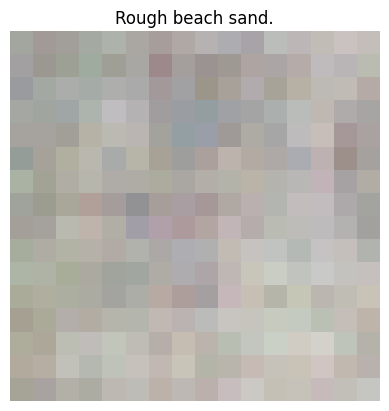

In [ ]:
# Display the generated texture
plt.imshow(generated_texture)
plt.title(description)
plt.axis('off')
plt.show()